<a href="https://colab.research.google.com/github/Shriyash11/GIRME/blob/main/sarcasmdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer



In [3]:
# Load the data
data = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)




In [4]:
# Data Preprocessing
data.drop(columns=['article_link'], inplace=True)
data["headline"] = data["headline"].str.lower()

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
data["headline"] = data["headline"].apply(lambda text: remove_punctuation(text))

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data["headline"] = data["headline"].apply(lambda text: remove_stopwords(text))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Word Frequency Analysis
cnt = Counter()
for text in data["headline"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
data["headline"] = data["headline"].apply(lambda text: remove_freqwords(text))

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
data["headline"] = data["headline"].apply(lambda text: remove_rarewords(text))

def preprocess_signs(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub('\s+', ' ', text).strip()
    return text
data['headline'] = data['headline'].apply(preprocess_signs)



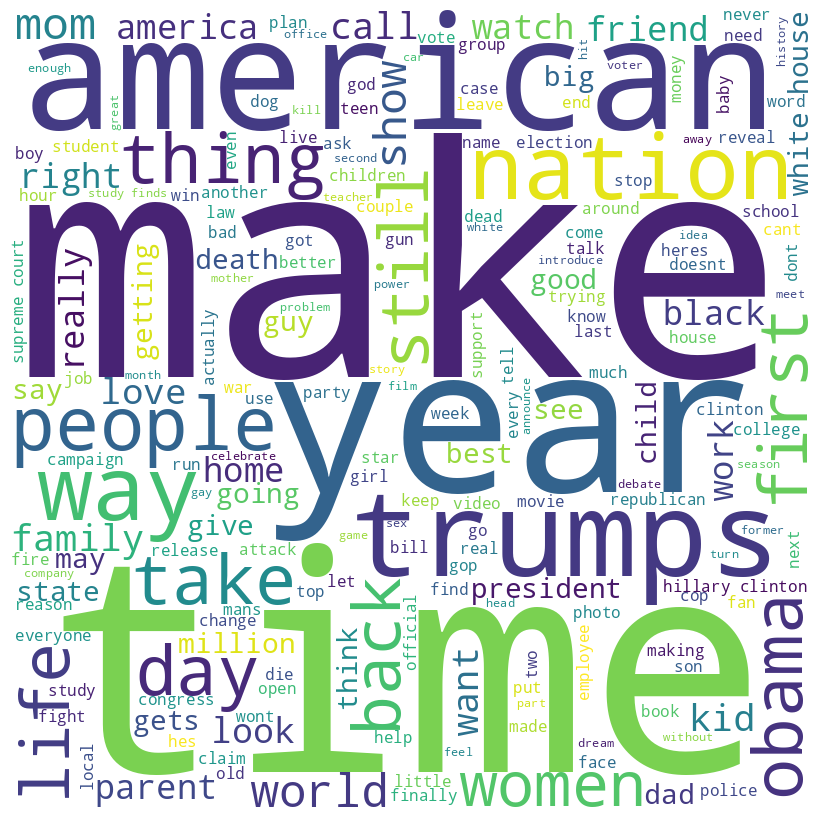

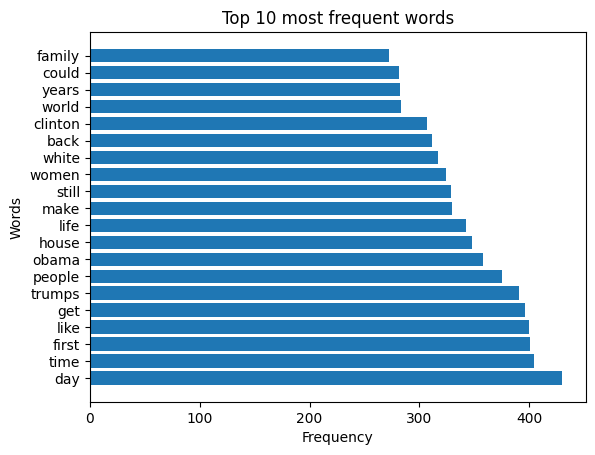

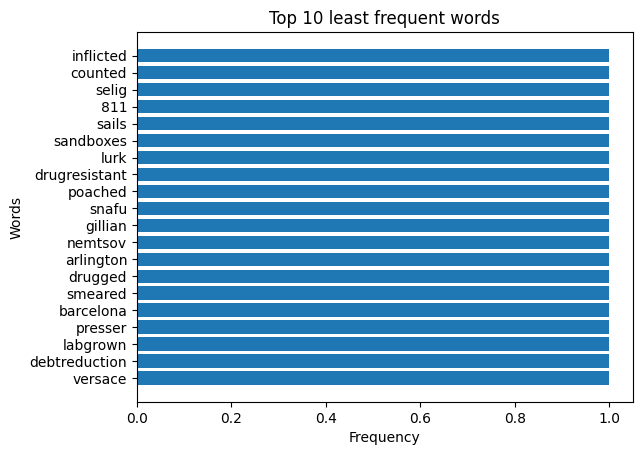

In [6]:
# Exploratory Data Analysis
data_ = " ".join(data["headline"])
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(data_)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

text = ' '.join(data['headline'].tolist())
word_counts = {}
for word in text.split():
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1

top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
plt.barh([word[0] for word in top_words], [word[1] for word in top_words])
plt.title('Top 10 most frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

least_frequent_words = sorted(word_counts.items(), key=lambda x: x[1])[:20]
plt.barh([word[0] for word in least_frequent_words], [word[1] for word in least_frequent_words])
plt.title('Top 10 least frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()



In [7]:
# Vectorization and Model Training
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['headline'])
y = data['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



In [8]:
# Model Evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

disp = classification_report(y_test, y_pred)
print(disp)



Accuracy: 0.7787345563459378
Confusion Matrix: [[2595  401]
 [ 781 1565]]
              precision    recall  f1-score   support

           0       0.77      0.87      0.81      2996
           1       0.80      0.67      0.73      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



In [14]:
# Prediction Function
def predict_sarcasm(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_freqwords(text)
    text = remove_rarewords(text)
    text = preprocess_signs(text)
    vectorized_text = vectorizer.transform([text])
    prediction = clf.predict(vectorized_text)[0]
    if prediction == 0:
        return "The text is not sarcastic."
    else:
        return "The text is sarcastic."

# Example usage
input_text = input("Enter text to predict sarcasm: ")
prediction = predict_sarcasm(input_text)
print(prediction)



Enter text to predict sarcasm: "Oh, great! Because nothing says 'fun' like spending another evening doing taxes. I was really looking forward to that!"
The text is sarcastic.
